In [10]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import autograd.numpy as np

from lib.graph import Graph
from simulator.fiber.assets.propagator import Propagator

from simulator.fiber.evaluator_subclasses.evaluator_rfawg import RadioFrequencyWaveformGeneration

from simulator.fiber.node_types_subclasses.inputs import ContinuousWaveLaser
from simulator.fiber.node_types_subclasses.outputs import Photodiode
from simulator.fiber.node_types_subclasses.single_path import PhaseModulator, WaveShaper, OpticalAmplifier
from simulator.fiber.node_types_subclasses.multi_path import VariablePowerSplitter
from simulator.fiber.node_types_subclasses.terminals import TerminalSource, TerminalSink

from algorithms.parameter_optimization import parameters_optimize


<AxesSubplot: >

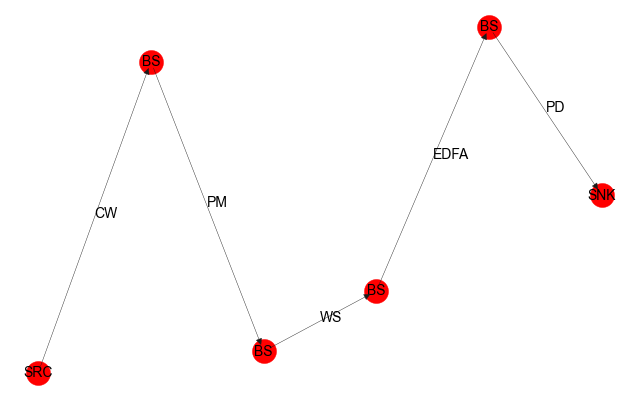

In [11]:
propagator = Propagator(window_t=10/12e9, n_samples=2**14, central_wl=1.55e-6)
evaluator = RadioFrequencyWaveformGeneration(propagator, target_harmonic=12e9, target_waveform='saw')

nodes = {'source': TerminalSource(),
         0: VariablePowerSplitter(),
         1: VariablePowerSplitter(),
         2: VariablePowerSplitter(),
         3: VariablePowerSplitter(),
         'sink': TerminalSink()}

edges = {('source', 0): ContinuousWaveLaser(),
         (0, 1): PhaseModulator(),
         (1, 2): WaveShaper(),
         (2, 3): OpticalAmplifier(),
         (3, 'sink'): Photodiode(),
         }

graph = Graph.init_graph(nodes, edges)
graph.update_graph()
graph.initialize_func_grad_hess(propagator, evaluator, exclude_locked=True)

graph.draw()

In [12]:
method = 'L-BFGS+GA'

graph.sample_parameters(probability_dist='uniform', **{'triangle_width': 0.1})
x0, models, parameter_index, *_ = graph.extract_parameters_to_list()
graph, x, score, log = parameters_optimize(graph, x0=x0, method=method, verbose=False)

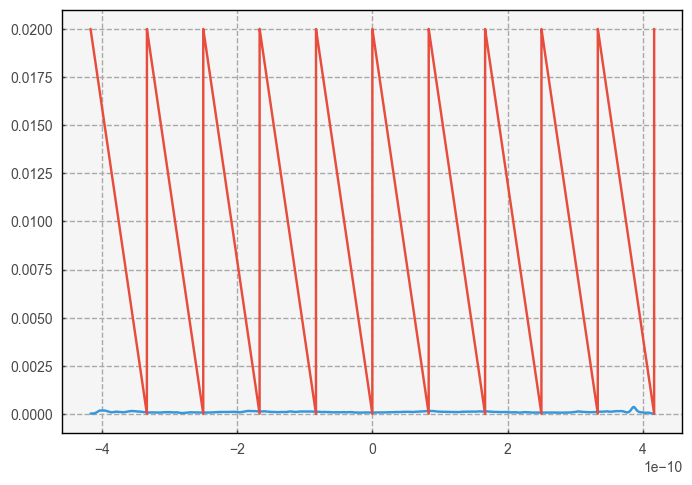

In [13]:
graph.distribute_parameters_from_list(x, models, parameter_index)
graph.propagate(propagator, save_transforms=False)
state = graph.measure_propagator('sink')

fig, ax = plt.subplots(1, 1)
ax.plot(propagator.t, np.power(np.abs(state), 2))
ax.plot(propagator.t, evaluator.target)